In [1]:
#Initialize variables
from sklearn.metrics import precision_score #import to test the accuracy of our predictions
from sklearn.ensemble import RandomForestClassifier #import RFC as model
model = RandomForestClassifier(n_estimators=2000, min_samples_split=500, random_state=1) #update RFC to have more estimators and less split
import yfinance as yf #where the data is grabbed
import pandas as pd #python statistic toolkit
ETFS = [] #store all etfs used as predictors

/Users/williamcheng/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#initialize TMF
tmf = yf.Ticker("TMF") #get the data on TMF
tmf = tmf.history(period="max") #get all time data on TMF
del tmf["Dividends"] #remove dividends and stock splits, unneeded
del tmf["Stock Splits"]
del tmf["Capital Gains"] #delete Capital Gains, unneeded
tmf["Tomorrow"] = tmf["Close"].shift(-1) #create a "tomorrow" column by taking the close value and shifting it back 1 row
tmf["Target"] = (tmf["Tomorrow"] > tmf["Close"]).astype(int) #create "Target", that is either 0 or 1 depending on whether Tomorrow's price is higher than Today's close


interest_rates = pd.read_csv('../FEDFUNDS.csv', parse_dates=["DATE"], index_col=["DATE"])
interest_rates.index #adding federal reserve rates to predict TMF
tmf = tmf.tz_localize(None)
tmf["interest"] = pd.Series(dtype='float64')
for i in range(0, tmf.shape[0]):
        if (tmf.index[i].strftime('%Y-%m') + '-01' == '2024-06-01'):
                tmf.at[tmf.index[i], "interest"] = float(5.33)
        else:
                tmf.at[tmf.index[i], "interest"] = interest_rates.at[tmf.index[i].strftime('%Y-%m') + '-01', "FEDFUNDS"]
tmf["Interest_Tomorrow"] = tmf["interest"].shift(-1) #create a "tomorrow" column by taking the close value and shifting it back 1 row
tmf["Interest_Target"] = (tmf["Interest_Tomorrow"] > tmf["interest"]).astype(int) #create "Target", that is either 0 or 1 depending on whether Tomorrow's price is higher than Today's close


horizons = [2, 5, 60, 250, 1000] #adding rolling mean close for the previous 2 days, week, three months, year, and four years
#use the ratio between the closing price now and the closing price then to make predictions
new_predictors = [] #to store the new rolling means
for horizon in horizons: #loop through the data in horizions, and calculate a rolling average for each time window
        rolling_averages = tmf.rolling(horizon).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        tmf[ratio_column] = tmf["Close"] / rolling_averages["Close"] #close price of the day / rolling avergage of "horizon" days

        trend_column = f"Trend_{horizon}" #the number of days in the past "horizon" days that the stock went up
        tmf[trend_column] = tmf.shift(1).rolling(horizon).sum()["Target"] #getting the sum of the target from the past "horizion" days

        interest_ratio = f"Interest_Ratio_{horizon}"
        tmf[interest_ratio] = tmf["Close"] / rolling_averages["interest"]

        interest_trend = f"Interest_Trend_{horizon}"
        tmf[interest_trend] = tmf.shift(1).rolling(horizon).sum()["Interest_Target"]

        new_predictors += [ratio_column, trend_column, interest_ratio, interest_trend]
tmf

,Open,High,Low,Close,Volume,Tomorrow,Target,interest,Interest_Tomorrow,Interest_Target,...,Interest_Ratio_60,Interest_Trend_60,Close_Ratio_250,Trend_250,Interest_Ratio_250,Interest_Trend_250,Close_Ratio_1000,Trend_1000,Interest_Ratio_1000,Interest_Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2009-04-16,106.956230,108.144226,105.951002,106.261711,4560,101.509735,0,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-17,104.543691,104.726460,100.906590,101.509735,12040,107.669014,1,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-20,104.470562,107.669014,104.470562,107.669014,2720,104.415749,0,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-21,110.410559,111.434071,104.379193,104.415749,6240,100.851761,0,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-22,104.360922,104.360922,99.608936,100.851761,10120,101.381798,1,0.15,0.15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,53.570000,54.279999,53.290001,53.980000,6863100,52.299999,0,5.33,5.33,0,...,10.127580,0.0,0.988618,121.0,10.176841,2.0,0.320184,478.0,23.170465,22.0
2024-06-17,52.049999,52.520000,51.599998,52.299999,6033600,53.750000,1,5.33,5.33,0,...,9.812383,0.0,0.959591,120.0,9.858252,2.0,0.310800,477.0,22.398862,22.0
2024-06-18,52.630001,53.799999,52.340000,53.750000,5541300,52.660000,0,5.33,5.33,0,...,10.084428,0.0,0.987942,120.0,10.129660,2.0,0.320036,477.0,22.968221,22.0


In [13]:
#Function to setup new ETF predictors, pass in original dataframe + the name you wish to give
def configureETF(etf, etf_name): 
        etf = etf.history(period="max")
        etf = etf.tz_localize(None)
        del etf["Dividends"]
        del etf["Capital Gains"]
        del etf["Stock Splits"]
        etf["Tomorrow"] = etf["Close"].shift(-1)
        etf[f"{etf_name}_Target"] = (etf["Tomorrow"] > etf["Close"]).astype('int')

        horizons = [2, 5, 60, 250, 1000] #adding rolling mean close for the previous 2 days, week, three months, year, and four years
        for horizon in horizons: #loop through the data in horizions, and calculate a rolling average for each time window
                etf_rolling_averages = etf.rolling(horizon).mean()

                etf_ratio_column = f"{etf_name}_Close_Ratio_{horizon}"
                etf[etf_ratio_column] = etf["Close"] / etf_rolling_averages["Close"] #close price of the day / rolling avergage of "horizon" days

                etf_trend_column = f"{etf_name}_Trend_{horizon}" #the number of days in the past "horizon" days that the stock went up
                etf[etf_trend_column] = etf.shift(1).rolling(horizon).sum()[f"{etf_name}_Target"] #getting the sum of the target from the past "horizion" days
        etf = etf.iloc[etf.shape[0]-3822:]
        return etf

        

In [16]:
#function to append an etf's predictors to the main TMF dataframe
def appendETF(etf):
        #remove all columns that are not used in predictions
        etf_predictors = etf.copy()
        del etf_predictors["Open"]
        del etf_predictors["High"]
        del etf_predictors["Low"]
        del etf_predictors["Close"]
        del etf_predictors["Volume"]
        del etf_predictors["Tomorrow"]
        return pd.concat([tmf, etf_predictors], axis=1)

In [19]:
#setup other ETF predictors

#set up BND
bnd = yf.Ticker("BND") #get data on BND
bnd = configureETF(bnd, "BND")
tmf = appendETF(bnd)
tmf

,Open,High,Low,Close,Volume,Tomorrow,Target,interest,Interest_Tomorrow,Interest_Target,...,BND_Close_Ratio_2,BND_Trend_2,BND_Close_Ratio_5,BND_Trend_5,BND_Close_Ratio_60,BND_Trend_60,BND_Close_Ratio_250,BND_Trend_250,BND_Close_Ratio_1000,BND_Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2009-04-16,106.956230,108.144226,105.951002,106.261711,4560,101.509735,0,0.15,0.15,0,...,0.999030,1.0,1.000648,3.0,1.009751,31.0,1.035499,131.0,NaN,NaN
2009-04-17,104.543691,104.726460,100.906590,101.509735,12040,107.669014,1,0.15,0.15,0,...,0.997339,0.0,0.995672,3.0,1.004359,31.0,1.029825,130.0,NaN,NaN
2009-04-20,104.470562,107.669014,104.470562,107.669014,2720,104.415749,0,0.15,0.15,0,...,1.002466,1.0,1.000259,3.0,1.009248,31.0,1.034727,130.0,NaN,NaN
2009-04-21,110.410559,111.434071,104.379193,104.415749,6240,100.851761,0,0.15,0.15,0,...,0.999028,1.0,0.998886,2.0,1.007210,31.0,1.032533,130.0,NaN,NaN
2009-04-22,104.360922,104.360922,99.608936,100.851761,10120,101.381798,1,0.15,0.15,0,...,1.000907,1.0,1.001193,2.0,1.008874,32.0,1.034197,131.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,53.570000,54.279999,53.290001,53.980000,6863100,52.299999,0,5.33,5.33,0,...,1.000758,2.0,1.006511,4.0,1.019370,35.0,1.033227,129.0,0.980777,492.0
2024-06-17,52.049999,52.520000,51.599998,52.299999,6033600,53.750000,1,5.33,5.33,0,...,0.998139,1.0,1.000608,4.0,1.015408,34.0,1.029270,128.0,0.977222,491.0
2024-06-18,52.630001,53.799999,52.340000,53.750000,5541300,52.660000,0,5.33,5.33,0,...,1.001724,1.0,1.002014,4.0,1.018737,34.0,1.032699,128.0,0.980686,491.0


In [20]:
#predict & backtest functions
#prediction and test function
def predict(test, predictors, train, model): #build an function for the testing of the model
        model.fit(train[predictors], train["Target"])
        preds = model.predict_proba(test[predictors])[:,1] #instead of returning 0 or 1, the prediction will return the probability of it being either 0 or 1 (with .predict_proba), and then get the second item in the array which is the probability of it going up
        preds[preds >= .6] = 1 #only predict that the stock goes up if the probability of it going up is over 60%
        preds[preds < .6] = 0 #otherwise predict that the stock goes down
        preds = pd.Series(preds, index = test.index, name="Predictions")
        combined = pd.concat([test["Target"], preds], axis=1)
        return combined

#backtesting algorithm
def backtest(data, model, predictors, start=2500, step=250): #backtesting: start at ten years time seeing ten years of historical data; step one year at a time
        all_predictions = [] #predictions for each year (step) is stored here

        for i in range(start, data.shape[0], step): #loop from 2500 to the end of the dataset, increasing i by 250 each time
                train = data.iloc[0:i].copy() #train from first entry to start entry (train with all years prior to current year)
                test = data.iloc[i:(i+step)].copy() #predict from start entry to start+step (predict upcoming year
                predictions = predict(test, predictors, train, model) #use prediction function to predict year
                all_predictions.append(predictions) #add the predictions for the current year to all_predictions
        return pd.concat(all_predictions) #takes the list of all predictions and combines them into one


In [22]:
tmf

,Open,High,Low,Close,Volume,Tomorrow,Target,interest,Interest_Tomorrow,Interest_Target,...,BND_Close_Ratio_2,BND_Trend_2,BND_Close_Ratio_5,BND_Trend_5,BND_Close_Ratio_60,BND_Trend_60,BND_Close_Ratio_250,BND_Trend_250,BND_Close_Ratio_1000,BND_Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2009-04-16,106.956230,108.144226,105.951002,106.261711,4560,101.509735,0,0.15,0.15,0,...,0.999030,1.0,1.000648,3.0,1.009751,31.0,1.035499,131.0,NaN,NaN
2009-04-17,104.543691,104.726460,100.906590,101.509735,12040,107.669014,1,0.15,0.15,0,...,0.997339,0.0,0.995672,3.0,1.004359,31.0,1.029825,130.0,NaN,NaN
2009-04-20,104.470562,107.669014,104.470562,107.669014,2720,104.415749,0,0.15,0.15,0,...,1.002466,1.0,1.000259,3.0,1.009248,31.0,1.034727,130.0,NaN,NaN
2009-04-21,110.410559,111.434071,104.379193,104.415749,6240,100.851761,0,0.15,0.15,0,...,0.999028,1.0,0.998886,2.0,1.007210,31.0,1.032533,130.0,NaN,NaN
2009-04-22,104.360922,104.360922,99.608936,100.851761,10120,101.381798,1,0.15,0.15,0,...,1.000907,1.0,1.001193,2.0,1.008874,32.0,1.034197,131.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,53.570000,54.279999,53.290001,53.980000,6863100,52.299999,0,5.33,5.33,0,...,1.000758,2.0,1.006511,4.0,1.019370,35.0,1.033227,129.0,0.980777,492.0
2024-06-17,52.049999,52.520000,51.599998,52.299999,6033600,53.750000,1,5.33,5.33,0,...,0.998139,1.0,1.000608,4.0,1.015408,34.0,1.029270,128.0,0.977222,491.0
2024-06-18,52.630001,53.799999,52.340000,53.750000,5541300,52.660000,0,5.33,5.33,0,...,1.001724,1.0,1.002014,4.0,1.018737,34.0,1.032699,128.0,0.980686,491.0


<Axes: xlabel='Date'>

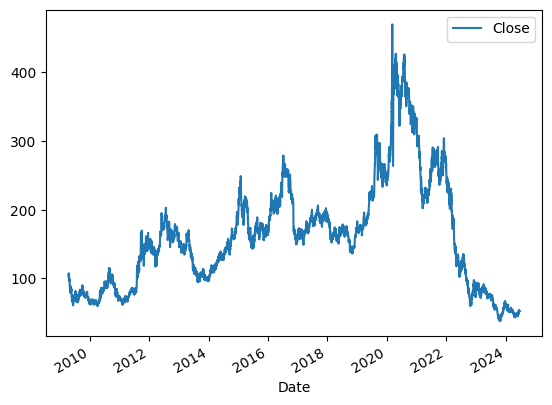

In [30]:
tmf.plot.line(y=["Close"], use_index=True)

<Axes: xlabel='Date'>

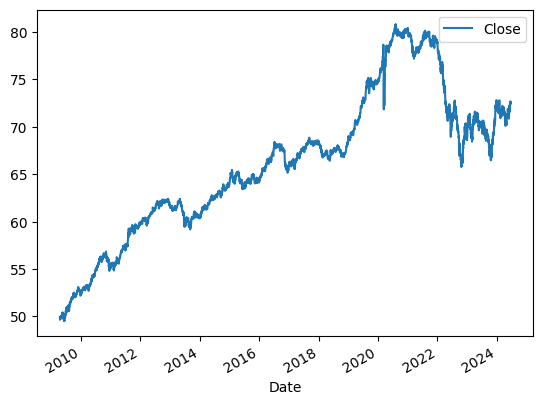

In [31]:
bnd.plot.line(y="Close", use_index=True)

In [40]:
droppedna_tmf = tmf.dropna()

In [50]:
new_predictors = ['Close_Ratio_2',
 'Trend_2',
 'Interest_Ratio_2',
 'Interest_Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Interest_Ratio_5',
 'Interest_Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Interest_Ratio_60',
 'Interest_Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Interest_Ratio_250',
 'Interest_Trend_250',
 'Close_Ratio_1000',
 'Trend_1000',
 'Interest_Ratio_1000',
 'Interest_Trend_1000',]

In [51]:
#learn and test
predictions = backtest(droppedna_tmf, model, new_predictors) #getting rid of original predictors (open, close, volume, high low) because an absolute value does little to predict trends

In [52]:
predictions["Predictions"].value_counts()

Predictions
0.0    295
1.0     26
Name: count, dtype: int64

In [53]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.6153846153846154)